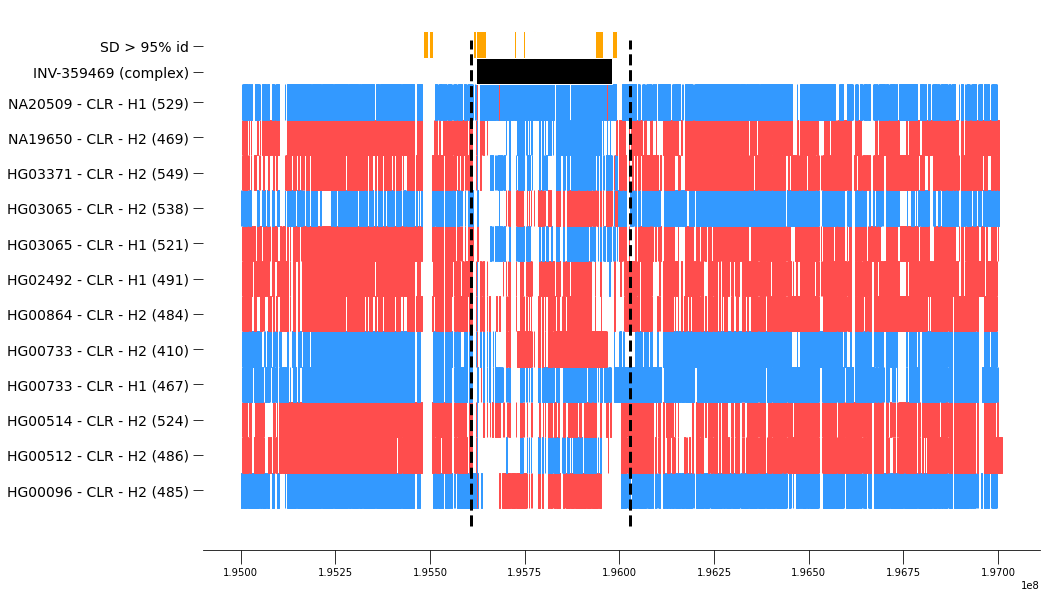

In [24]:
import os
import pandas as pd

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

path = '/home/ebertp/mounts/hhu/project/ebertp/projects/rfdga/production/EVAL/run_folder/output/evaluation/bng_hybrids'

haps = """
AFR-HG02011-H1
AFR-HG03065-H1
AFR-HG03065-H2
AMR-HG00731-H2
EAS-HG00512-H1
EAS-HG00513-H1
EAS-HG00514-H2
EAS-HG00864-H2
EAS-NA18534-H1
EAS-NA18534-H2
EAS-GM18939-H2
EUR-HG00096-H2
EUR-HG00171-H2
SAS-HG02492-H2
"""

hap_map = {
    'H1': 'h1-un',
    'H2': 'h2-un'
}

cache = set()

# for root, dirs, files in os.walk(path):
#     files = [os.path.join(root, f) for f in files if f.endswith('chr3.fasta')]
#     cache.update(set(files))

# for hap in haps.strip('"').split():
#     pop, sample, haplot = hap.split('-')
#     h = hap_map[haplot]
#     select = [f for f in cache if sample in f and h in f]
#     for s in select:
#         print(s)
    
mum_path = '/home/local/work/data/hgsvc/roi/dotplots_chr3/mums'

frw_color = (0.2, 0.6, 1)
rev_color = (1, 0.3, 0.3)

rows = []
for mum_file in sorted(os.listdir(mum_path)):
    if '5000' in mum_file or '250' in mum_file:
        continue
    sample, tech, hap = mum_file.split('.')[0].split('_')
    file_path = os.path.join(mum_path, mum_file)
    current_seq = ''
    with open(file_path, 'r') as table:
        for line in table:
            if line.startswith('>'):
                current_seq = line.strip()
                continue
            ref_chrom, ref_start, qry_start, match_len = line.strip().split()
            if 195e6 < int(ref_start) < 197e6:
                if 'Reverse' in current_seq:
                    rows.append((sample, tech, hap, int(ref_start), int(match_len), rev_color))
                else:
                    rows.append((sample, tech, hap, int(ref_start), int(match_len), frw_color))
                    
df = pd.DataFrame(rows, columns=['sample', 'tech', 'hap', 'start', 'length', 'color'])
df.sort_values(['sample', 'tech', 'hap', 'start'], inplace=True)

samples = [
    ('HG00096', 'CLR', 'H2'),
    ('HG00512', 'CLR', 'H2'),
    ('HG00514', 'CLR', 'H2'),
    ('HG00733', 'CLR', 'H1'),
    ('HG00733', 'CLR', 'H2'),
    ('HG00864', 'CLR', 'H2'),
    ('HG02492', 'CLR', 'H1'),
    ('HG03065', 'CLR', 'H1'),
    ('HG03065', 'CLR', 'H2'),
    ('HG03371', 'CLR', 'H2'),
    ('NA19650', 'CLR', 'H2'),
    ('NA20509', 'CLR', 'H1')
]


# add segdups
sd = pd.read_csv(
    '/home/local/work/code/github/project-diploid-assembly/annotation/grch38/GRCh38_segdups.bed',
    sep='\t',
    header=0
)
sd = sd.loc[sd['#chrom'] == 'chr3', :].copy()
sd = sd.loc[sd['name'].str.contains('chr3'), :].copy()
sd = sd.loc[(195e6 < sd['chromStart']) & (sd['chromStart'] < 197e6), :].copy()


# Figure stuff

width = 15
height = 10

fig, ax = plt.subplots(figsize=(width, height))

y_start = 0
y_labels = []
y_label_pos = []
legend_patches = []
max_plot = 0

for (sample, tech, hap), matches in df.groupby(['sample', 'tech', 'hap']):
    if (sample, tech, hap) not in samples:
        continue
    y_labels.append('{} - {} - {} ({})'.format(sample, tech, hap, matches.shape[0]))
    y_label_pos.append(y_start + 0.5)
    barh_xranges = []
    barh_colors = []
    for idx, match in matches.iterrows():
        x_min = match['start']
        x_width = match['length']
        x_max = x_min + x_width
        max_plot = max(max_plot, x_max)
        barh_xranges.append((x_min, x_width))
        barh_colors.append(match['color'])

    ax.broken_barh(
        barh_xranges,
        (y_start, 1),
        edgecolor='face',
        facecolors=barh_colors,
        zorder=10
    )
    y_start += 1
    
ax.broken_barh(
    [(195620739, 195980207 - 195620739)],
    (y_start, 0.75),
    edgecolor='white',
    facecolor='black',
    zorder=10
)
#chr3    195620739       195980207

y_label_pos.append(y_start + 0.35)
#y_labels.append('chr3-195620740-INV-359469 (complex)')
y_labels.append('INV-359469 (complex)')

y_start += 0.75

sd_bars = []
for idx, row in sd.iterrows():
    if row['score'] < 950:
        continue
    sd_bars.append((row['chromStart'], row['chromEnd'] - row['chromStart']))
    
ax.broken_barh(
    sd_bars,
    (y_start, 0.75),
    edgecolor='white',
    facecolor='orange',
    zorder=10
)
#chr3    195620739       195980207

y_label_pos.append(y_start + 0.35)
#y_labels.append('chr3-195620740-INV-359469 (complex)')
y_labels.append('SD > 95% id')
        

_ = ax.set_yticks(y_label_pos)
_ = ax.set_yticklabels(y_labels, fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.vlines(
    [195607154, 196027006],
    -0.5, y_start+0.5,
    ls='dashed',
    zorder=20,
    lw=3,
    colors=['black', 'black']
)

ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', length=10)
ax.tick_params(axis='x', which='major', length=10, size=14)
